In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar10
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd

2024-09-04 22:35:31.905270: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-04 22:35:31.941180: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 22:35:32.826183: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Carregar os dados CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Verificar as formas dos conjuntos de dados
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

In [3]:
# Normalizar os dados
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [4]:
# Separar um conjunto de validação manualmente
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=0.2, random_state=42)

In [5]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", 
               "dog", "frog", "horse", "ship", "truck"]

In [ ]:
#  Early stopping set after 4 epochs
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

# Funções úteis

In [6]:
# defining the function
def evaluate_model(model, X_test, y_test):

    # Evauting the model using teh testing dataset
    eval_dict = model.evaluate(X_test, y_test, return_dict=True)
    
    # converting the evaluation ( accuracy and loss) to pandas dataframe
    result = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])
    
    # returining dataframe
    return result

In [7]:
# Perda (erro) no treino e validação ao longo das épocas
def plot_loss(history, name):
    plt.plot(history.history['loss'], label='Erro Treino')
    plt.plot(history.history['val_loss'], label='Erro Validação')
    plt.title('Erro por Época - ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('Erro (Perda)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Modelo Baseline

In [8]:
#model = tf.keras.Sequential([
#    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
#    tf.keras.layers.Dense(128, activation='relu'),
#    tf.keras.layers.Dense(10, activation='softmax')
#])

# Definir o modelo
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

In [9]:
model = build_model()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

/home/yagoth/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,634 (1.51 MB)

 Trainable params: 394,634 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Função para treinar e avaliar o modelo sem data augmentation
def train_without_augmentation():
    model = build_model()
    history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), callbacks=[stop_early], verbose=2)
    results = evaluate_model(model, x_test, y_test)
    return results, history

In [13]:
# Aplicando data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Preparando o gerador de dados com data augmentation
datagen.fit(x_train)

# Função para treinar e avaliar o modelo com data augmentation
def train_with_augmentation():
    model = build_model()
    history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                        epochs=10,
                        validation_data=(x_val, y_val),
                        callbacks=[stop_early],
                        verbose=2)
    results = evaluate_model(model, x_test, y_test)
    return results, history

In [14]:
# Treinando sem data augmentation
print("Treinando sem data augmentation...")
results_no_aug, hist_no_aug = train_without_augmentation()

# Treinando com data augmentation
print("Treinando com data augmentation...")
results_with_aug, hist_with_aug = train_with_augmentation()

Treinando sem data augmentation...


/home/yagoth/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1250/1250 - 3s - 2ms/step - accuracy: 0.3109 - loss: 1.9229 - val_accuracy: 0.3220 - val_loss: 1.8585
Epoch 2/10
1250/1250 - 2s - 2ms/step - accuracy: 0.3702 - loss: 1.7716 - val_accuracy: 0.3774 - val_loss: 1.7423
Epoch 3/10
1250/1250 - 3s - 2ms/step - accuracy: 0.3907 - loss: 1.7122 - val_accuracy: 0.3850 - val_loss: 1.7028
Epoch 4/10
1250/1250 - 3s - 2ms/step - accuracy: 0.3976 - loss: 1.6841 - val_accuracy: 0.3923 - val_loss: 1.6884
Epoch 5/10
1250/1250 - 2s - 2ms/step - accuracy: 0.4100 - loss: 1.6585 - val_accuracy: 0.4093 - val_loss: 1.6534
Epoch 6/10
1250/1250 - 2s - 2ms/step - accuracy: 0.4173 - loss: 1.6407 - val_accuracy: 0.4099 - val_loss: 1.6458
Epoch 7/10
1250/1250 - 3s - 2ms/step - accuracy: 0.4214 - loss: 1.6238 - val_accuracy: 0.4180 - val_loss: 1.6300
Epoch 8/10
1250/1250 - 2s - 2ms/step - accuracy: 0.4254 - loss: 1.6137 - val_accuracy: 0.3980 - val_loss: 1.6519
Epoch 9/10
1250/1250 - 2s - 2ms/step - accuracy: 0.4309 - loss: 1.6008 - val_accuracy: 0.4343 - 

/home/yagoth/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


/home/yagoth/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 - 12s - 10ms/step - accuracy: 0.2432 - loss: 2.0646 - val_accuracy: 0.3055 - val_loss: 1.9094
Epoch 2/10
1250/1250 - 12s - 9ms/step - accuracy: 0.2808 - loss: 1.9673 - val_accuracy: 0.3254 - val_loss: 1.8466
Epoch 3/10
1250/1250 - 12s - 9ms/step - accuracy: 0.2869 - loss: 1.9442 - val_accuracy: 0.3230 - val_loss: 1.8546
Epoch 4/10
1250/1250 - 12s - 9ms/step - accuracy: 0.2946 - loss: 1.9257 - val_accuracy: 0.3251 - val_loss: 1.8726
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.3346 - loss: 1.8613


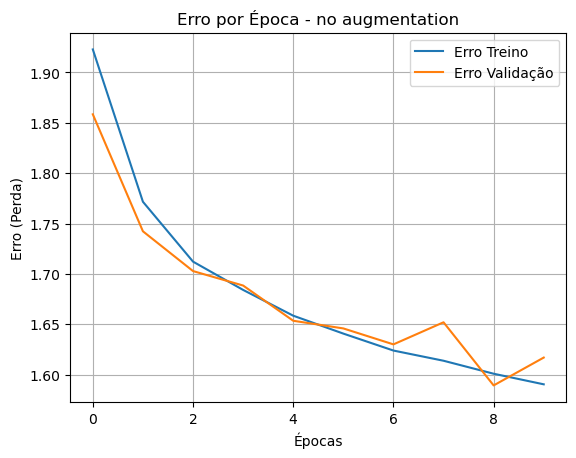

In [15]:
plot_loss(hist_no_aug, 'no augmentation')

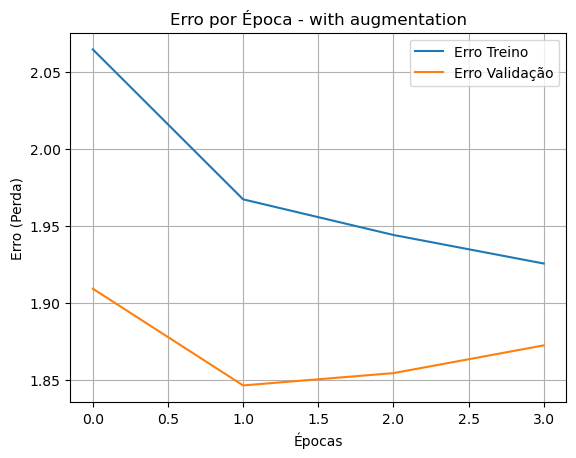

In [16]:
plot_loss(hist_with_aug, 'with augmentation')

In [17]:
# Comparando os resultados
print("Resultados sem data augmentation:")
print(results_no_aug)

print("Resultados com data augmentation:")
print(results_with_aug)

Resultados sem data augmentation:
  accuracy      loss
0   0.4232  1.609817
Resultados com data augmentation:
  accuracy      loss
0   0.3318  1.863941


# Hyperparameter Tuning

In [ ]:
# creating function
def build_model(hyper_parameter):

    # building the model
    model = tf.keras.Sequential()

    # flattenting the images
    model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))

    # tunning hidden layers (1-3), units ( 50 -300),
    for i in range(1, hyper_parameter.Int("num_layers", 2, 4)):
        model.add(
            tf.keras.layers.Dense(
                units=hyper_parameter.Int("units_" + str(i), min_value=50, max_value=300, step=30),
                activation="relu")
            )
        
        # drop out layer with values form 0-0.3
        model.add(tf.keras.layers.Dropout(hyper_parameter.Float("dropout_" + str(i), 0, 0.3, step=0.1)))
    
    # Add output layer.
    model.add(tf.keras.layers.Dense(units=10, activation="softmax"))
    
    # Tune learning from 0.01, 0.001
    hyper_parameter_learning_rate = hyper_parameter.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hyper_parameter_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    
    return model

In [ ]:
# early stop function for hyperparameter tuning of neural network
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

## Hyperband

In [ ]:
# importing the karas tuner
import kerastuner as kt

# Instantiate the tuner
tuner = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=10,
                     directory="kt_dir",
                     project_name="kt_hyperband",)

In [ ]:
# Tunner search
tuner.search(x_train, y_train, epochs=20, validation_split=0.2, callbacks=[stop_early], verbose=2)

## Random Search

In [ ]:
from keras_tuner import RandomSearch


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  # O objetivo a ser otimizado
    max_trials=3,  # Número de combinações de hiperparâmetros para testar
    executions_per_trial=3,  # Número de execuções para cada conjunto de hiperparâmetros
    #directory='my_dir',  # Diretório para salvar os resultados
    project_name='random_search_example'
)

In [ ]:
# summary of tuner
tuner.search_space_summary()

In [ ]:
tuner.search(x_train, y_train,
             epochs=5,
             validation_data=(x_val, y_val),
            callbacks=[stop_early])

## Treina com melhores hiperparâmetros

In [ ]:
# Get the optimum values for parameters
best_hps=tuner.get_best_hyperparameters()[0]

# Build model on optimum paramters
optimum_model = tuner.hypermodel.build(best_hps)

# Train the hypertuned model
history = optimum_model.fit(x_train, y_train, validation_data=(x_val, y_val),
                            callbacks=[stop_early], epochs=20, verbose=2)

In [ ]:
plot_loss(history, 'optimum_model')

In [ ]:
# get te optimum models results
hyper_df = evaluate_model(optimum_model, x_test, y_test)

# adding result to the dataframe already created
#results.append(hyper_df)

# printing the results
hyper_df.head()

# Referências

- https://www.tensorflow.org/tutorials/keras/classification#build_the_model
- https://pyihub.org/hyperparameter-tuning-of-neural-network/
- https://github.com/YounesElhjouji/Fully-Connected-Cifar10-Classifier/blob/master/CIFAR10-Classifier.ipynb
- https://github.com/Mostafa-Mansour/Image-classification-using-a-fully-connected-neural-network-/blob/master/Image%20classification%20using%20Keras.ipynb